# Driving14x14WideRoundAbout-n2-v0 KLR Experiment analysis

In [16]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "Driving", "Driving14x14WideRoundAbout-n2-v0", "results", "klr_experiment_results_v0.csv"
)
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {1: {
    'klr_k0_seed0-v0': 0.25,
    'klr_k1_seed0-v0': 0.25,
    'klr_k2_seed0-v0': 0.25,
    'klr_k3_seed0-v0': 0.25,
}}
coplayer_policy_ids = list(policy_prior[1])
print(f"{coplayer_policy_ids=}")
fixed_policy_ids = [*coplayer_policy_ids] + ["klr_k4_seed0-v0"]
print(f"{fixed_policy_ids=}")

coplayer_policy_ids=['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0']
fixed_policy_ids=['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0', 'klr_k4_seed0-v0']


## Loading Heuristic Policy Data

In [3]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("Policies")
print("--------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

Policies
--------
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0

Columns
-------
   exp_id
   agent_id
   env_id
   policy_id
   exp_seed
   num_episodes
   episode_return_mean
   episode_return_std
   episode_return_max
   episode_return_min
   episode_steps_mean
   episode_steps_std
   episode_time_mean
   episode_time_std
   num_episode_done
   num_LOSS
   num_DRAW
   num_WIN
   num_NA
   episode_return_CI
   episode_steps_CI
   episode_time_CI
   prop_LOSS
   prop_DRAW
   prop_WIN
   prop_NA
   num_sims
   coplayer_policy_id


### Heuristic policies pairwise performance

This is what was used to generate the meta-policies.

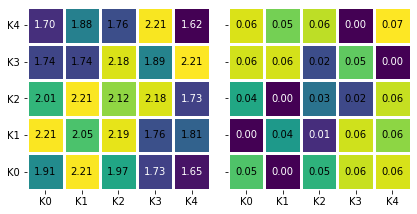

In [5]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_policy_ids,
    policy_labels={
        "klr_k0_seed0-v0": "K0",
        "klr_k1_seed0-v0": "K1",
        "klr_k2_seed0-v0": "K2",
        "klr_k3_seed0-v0": "K3",
        "klr_k4_seed0-v0": "K4"
    },
    average_duplicates=True,
    duplicate_warning=False
)

### Add Full-Knowledge Best-Response baseline

In [6]:
best_response_map = {
    "klr_k0_seed0-v0": "klr_k1_seed0-v0",
    "klr_k1_seed0-v0": "klr_k2_seed0-v0",
    "klr_k2_seed0-v0": "klr_k3_seed0-v0",
    "klr_k3_seed0-v0": "klr_k4_seed0-v0",
    # FYI K4 is added but is not used in expected results, 
    # since K4 not in other policy prior
    "klr_k4_seed0-v0": "klr_k3_seed0-v0",
}

new_rows = []
for coplayer_policy_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    br_row = policy_df.loc[
        # use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
        (policy_df["agent_id"] == 0)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
    ].copy()
    br_coplayer_row = policy_df.loc[
        (policy_df["agent_id"] == 1)
        & (policy_df["exp_id"].isin(br_row["exp_id"]))
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    br_row["exp_id"] = next_exp_id
    br_coplayer_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]

10
10
220


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,episode_return_mean,episode_return_std,episode_return_max,episode_return_min,...,num_NA,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,coplayer_policy_id
210,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.20970,0.069720,2.3,2.1,...,0,0.004321,0.116152,0.038302,0.000,0.0,1.000,0.0,0,klr_k0_seed0-v0
212,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21225,0.070869,2.3,2.1,...,0,0.004393,0.217854,0.036358,0.000,0.0,1.000,0.0,0,klr_k1_seed0-v0
214,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.18125,0.298297,2.3,-0.6,...,0,0.018489,0.133130,0.039960,0.011,0.0,0.989,0.0,0,klr_k2_seed0-v0
216,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21325,0.068498,2.3,2.1,...,0,0.004246,0.102640,0.043274,0.000,0.0,1.000,0.0,0,klr_k3_seed0-v0
218,238,0,Driving14x14WideRoundAbout-n2-v0,full-knowledge-br,0,1000,2.21435,0.069689,2.3,2.1,...,0,0.004319,0.104956,0.043259,0.000,0.0,1.000,0.0,0,klr_k4_seed0-v0


## Loading BAPOSGMCP Data

In [26]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print(f'  "{pi_id}",')

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print(f'  "{c}",')

Policies
--------
  "POMetaRollout_pucb_10",
  "POMetaRollout_pucb_100",
  "POMetaRollout_pucb_1000",
  "POMetaRollout_pucb_50",
  "POMetaRollout_pucb_500",
  "POMeta_10",
  "POMeta_100",
  "POMeta_1000",
  "POMeta_50",
  "POMeta_500",
  "baposgmcp_10",
  "baposgmcp_100",
  "baposgmcp_1000",
  "baposgmcp_50",
  "baposgmcp_500",
  "klr_k0_seed0-v0",
  "klr_k1_seed0-v0",
  "klr_k2_seed0-v0",
  "klr_k3_seed0-v0",
  "klr_k4_seed0-v0",
  "metabaseline",

Columns
-------
  "policy_id",
  "coplayer_policy_id",
  "exp_id",
  "exp_seed",
  "agent_id",
  "env_id",
  "time_limit",
  "episode_step_limit",
  "discount",
  "c_init",
  "c_base",
  "truncated",
  "action_selection",
  "dirichlet_alpha",
  "root_exploration_fraction",
  "known_bounds",
  "extra_particles_prop",
  "step_limit",
  "epsilon",
  "belief_size",
  "other_policy_dist",
  "meta_policy_dict",
  "num_sims",
  "num_episodes",
  "num_WIN",
  "num_LOSS",
  "num_DRAW",
  "num_NA",
  "search_time_mean",
  "search_time_std",
  "search

In [27]:
rename_map = {
    "POMetaRollout_pucb_10": "POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue",
    "POMetaRollout_pucb_100": "POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue",
    "POMetaRollout_pucb_1000": "POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue",
    "POMetaRollout_pucb_50": "POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue",
    "POMetaRollout_pucb_500": "POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue",
    "POMeta_10": "POMeta_greedy_numsims10",
    "POMeta_100": "POMeta_greedy_numsims100",
    "POMeta_1000": "POMeta_greedy_numsims1000",
    "POMeta_50": "POMeta_greedy_numsims50",
    "POMeta_500": "POMeta_greedy_numsims500",
    "baposgmcp_10": "baposgmcp_greedy_numsims10_actionselectionpucb_truncatedTrue",
    "baposgmcp_100": "baposgmcp_greedy_numsims100_actionselectionpucb_truncatedTrue",
    "baposgmcp_1000": "baposgmcp_greedy_numsims1000_actionselectionpucb_truncatedTrue",
    "baposgmcp_50": "baposgmcp_greedy_numsims50_actionselectionpucb_truncatedTrue",
    "baposgmcp_500": "baposgmcp_greedy_numsims500_actionselectionpucb_truncatedTrue",
    "metabaseline": "metabaseline_greedy", 
}


def rename_policy(row):
    policy_id = row["policy_id"]
    return rename_map.get(policy_id, policy_id)


baposgmcp_df["policy_id"] = baposgmcp_df.apply(rename_policy, axis=1)
    
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print(f'  "{pi_id}",')

Policies
--------
  "POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue",
  "POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue",
  "POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue",
  "POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue",
  "POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue",
  "POMeta_greedy_numsims10",
  "POMeta_greedy_numsims100",
  "POMeta_greedy_numsims1000",
  "POMeta_greedy_numsims50",
  "POMeta_greedy_numsims500",
  "baposgmcp_greedy_numsims1000_actionselectionpucb_truncatedTrue",
  "baposgmcp_greedy_numsims100_actionselectionpucb_truncatedTrue",
  "baposgmcp_greedy_numsims10_actionselectionpucb_truncatedTrue",
  "baposgmcp_greedy_numsims500_actionselectionpucb_truncatedTrue",
  "baposgmcp_greedy_numsims50_actionselectionpucb_truncatedTrue",
  "klr_k0_seed0-v0",
  "klr_k1_seed0-v0",
  "klr_k2_seed0-v0",
  "klr_k3_seed0-v0",
  "klr_k4_seed0-v0",
  "metabaseline_greedy",


## Combine data

In [28]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)

def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("klr"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    

alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in combined_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue
   POMeta_greedy_numsims10
   POMeta_greedy_numsims100
   POMeta_greedy_numsims1000
   POMeta_greedy_numsims50
   POMeta_greedy_numsims500
   baposgmcp_greedy_numsims1000_actionselectionpucb_truncatedTrue
   baposgmcp_greedy_numsims100_actionselectionpucb_truncatedTrue
   baposgmcp_greedy_numsims10_actionselectionpucb_truncatedTrue
   baposgmcp_greedy_numsims500_actionselectionpucb_truncatedTrue
   baposgmcp_greedy_numsims50_actionselectionpucb_truncatedTrue
   full-knowledge-br
   klr_k0_seed0-v0
   klr_k1_seed0-v0
   klr_k2_seed0-v0
   klr_k3_seed0-v0
   klr_k4_seed0-v0
   metabaseline_greedy

Alg IDs
-------
   POMeta
   POMeta

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP using different number of simulations.

(<Figure size 1080x1584 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

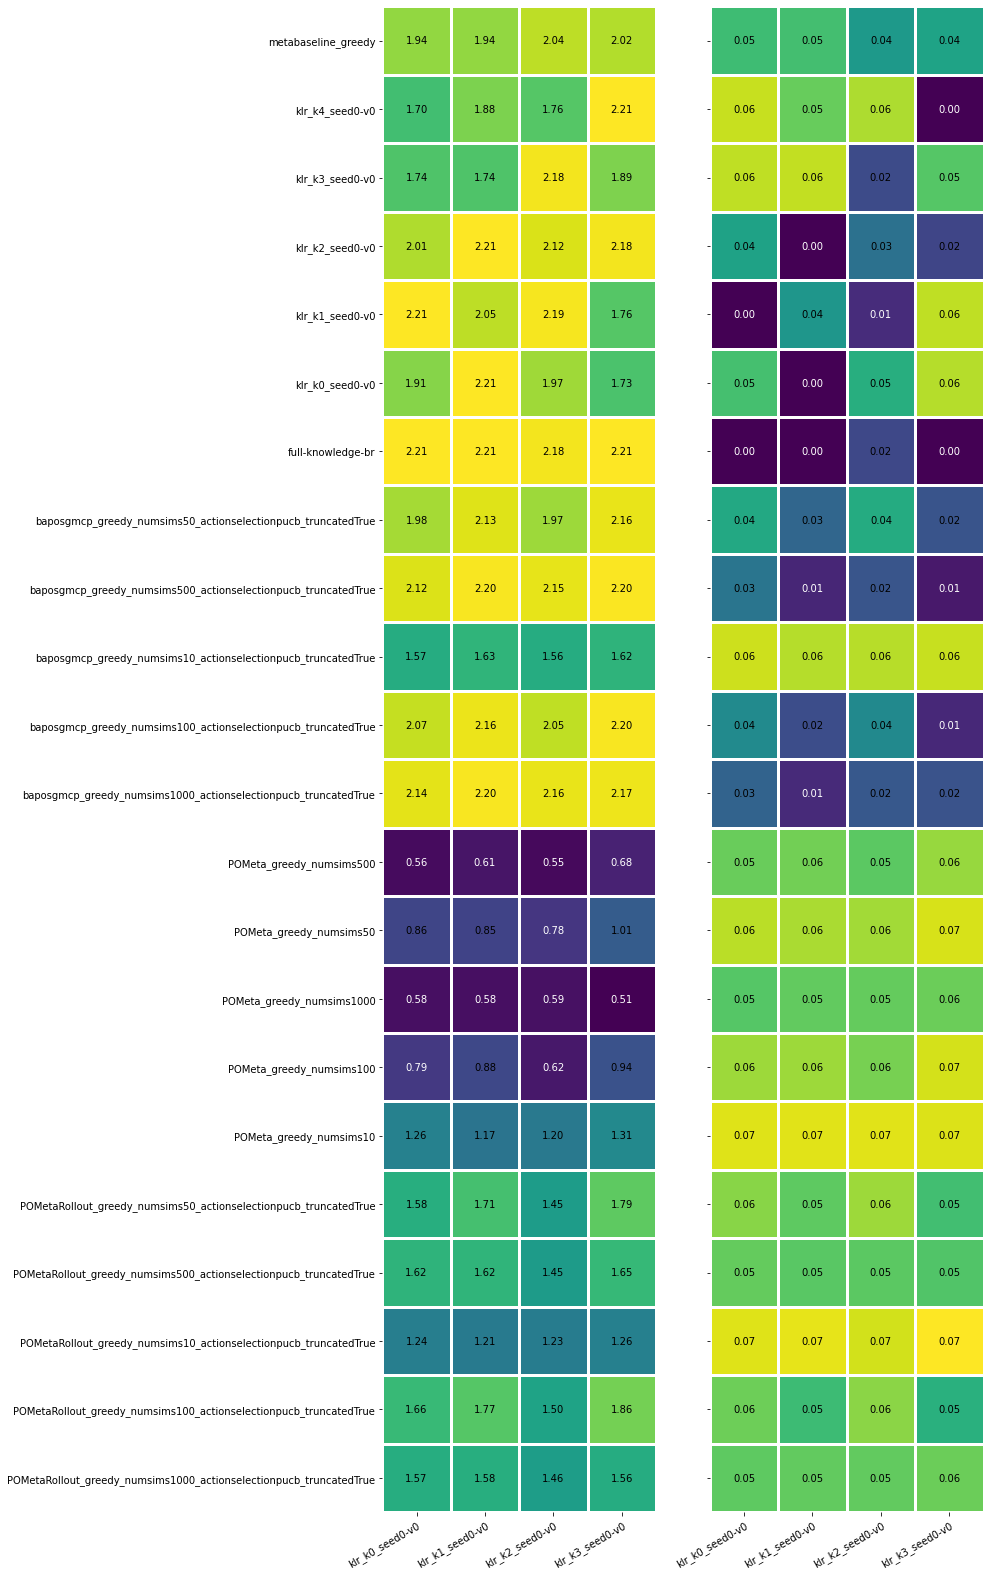

In [29]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(15, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 720x1584 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

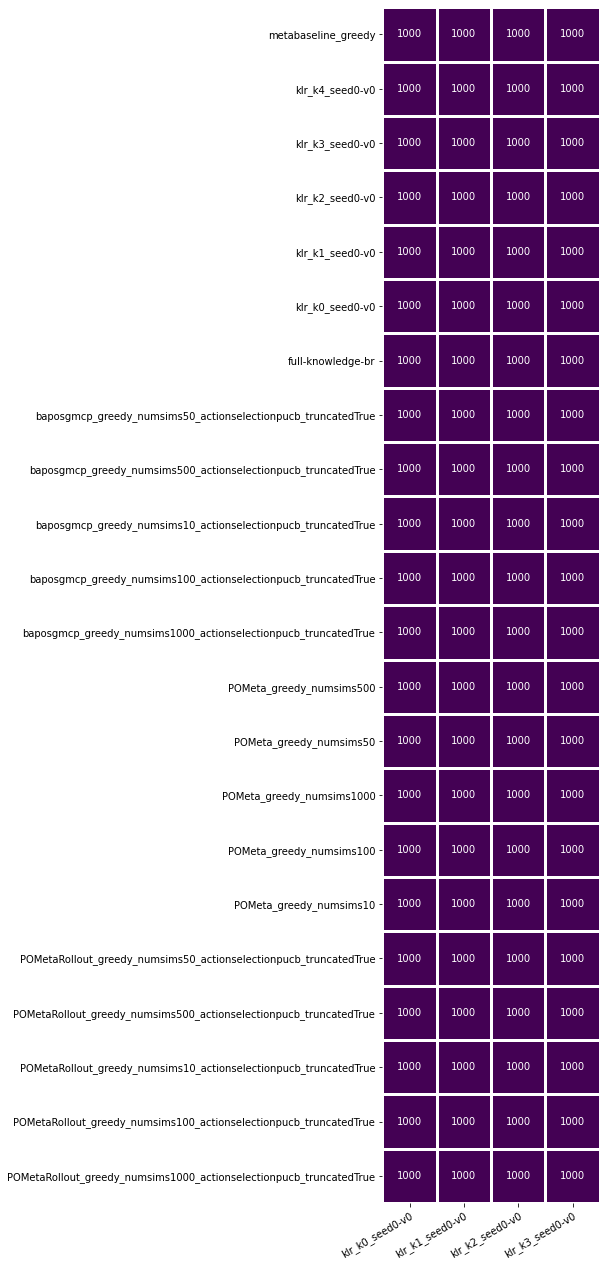

In [30]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(10, len(combined_df["policy_id"].unique())),
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [31]:
exp_df = plot_utils.get_uniform_expected_df(combined_df, policy_prior)

Ungrouped size = 112
Grouped size = 22


In [32]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

### Action Selection

### Comparison of truncation

### Comparison of the different Meta-Policies

### Comparing Meta-Policy versus no meta-policy

### Comparing BAPOSGMCP versus baselines

In [33]:
perf_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline", "full-knowledge-br"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

policy_prefixes_to_plot = [
    "baposgmcp_greedy",
    "POMeta_greedy",
    "POMetaRollout_greedy",
    "metabaseline_greedy",
    "full-knowledge-br"
]

baseline_pi_label_map = {
    "baposgmcp_greedy": "BAPOSGMCP",
    "POMeta_greedy": "POMeta", 
    "POMetaRollout_greedy": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
    "full-knowledge-br": "Best-Response"
}

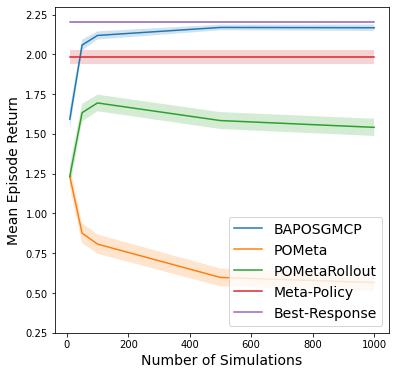

In [34]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.25, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

# fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [35]:
belief_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
print(belief_gb_df)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
Ungrouped size = 15
Grouped size = 15
           alg_id  num_sims  exp_id  exp_seed coplayer_policy_id  agent_id  \
0          POMeta        10     255         0    klr_k0_seed0-v0         0   
5   POMetaRollout        10     280         0    klr_k0_seed0-v0         0   
10      baposgmcp        10       0         0    klr_k0_seed0-v0         0   
1          POMeta        50     260         0    klr_k0_seed0-v0         0   
6   POMetaRollout        50     285         0    klr_k0_seed0-v0         0   
11      baposgmcp        50       5         0    klr_k0_seed0-v0         0   
2          POMeta       100     265         0    klr_k0_seed0-v0         0   
7   POMetaRollout       100     290         0    klr_k0_seed0-v0         0   
12      baposgmcp       100      10         0    klr_k0_seed0-v0         0   
3          POMeta       500     270         0    klr_k0_seed0-v0         0   
8   POMetaRollout       500     295         0    klr_k0_s

In [36]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    "title": "Num. Sims." 
})

POMeta
POMetaRollout
baposgmcp


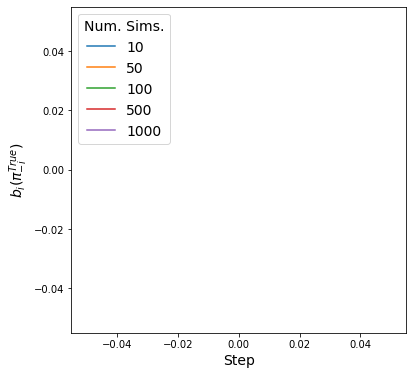

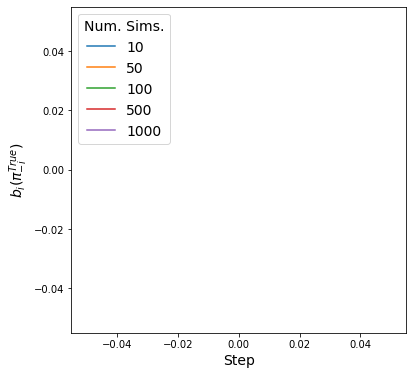

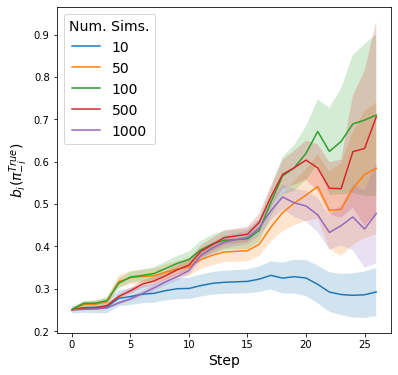

In [38]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r'$b_{i}(\pi_{-i}^{True})$'
    # "ylim": (1.5, 2.3),
})

for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="bayes_accuracy",
        step_limit=27,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )

    # fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp


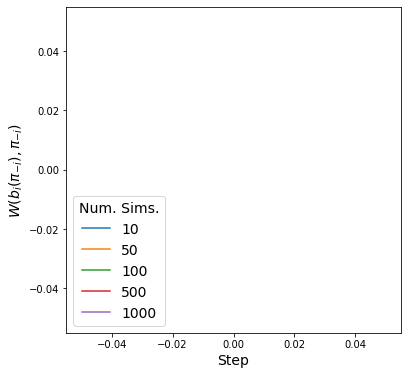

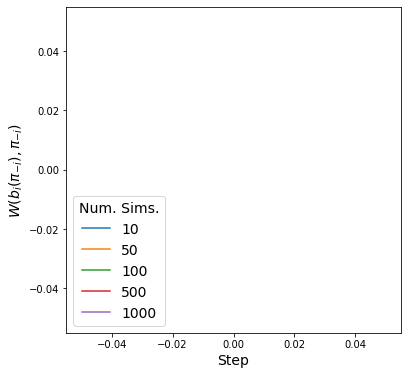

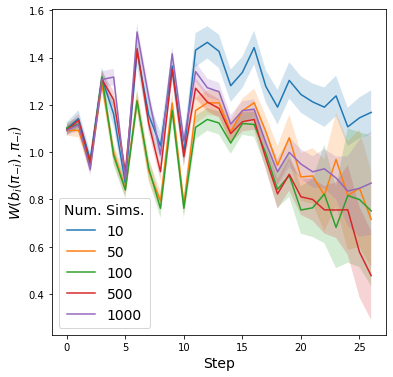

In [41]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r"$W(b_{i}(\pi_{-i}), \pi_{-i})$"
    # "ylim": (1.5, 2.3),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "lower left",
})


for alg_id in belief_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_belief_stats(
        belief_gb_df[belief_gb_df["alg_id"] == alg_id],
        y_key_prefix="action_dist_distance",
        step_limit=27,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
        alg_id_key="alg_id",
        **plot_kwargs
    )
    
del plot_kwargs

# Old version

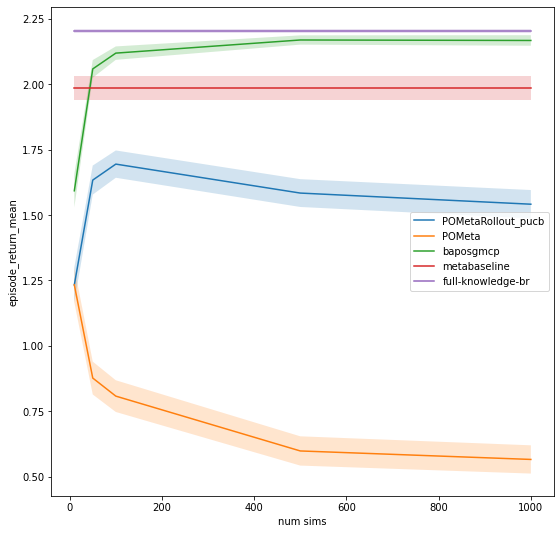

In [81]:
plot_utils.plot_expected_values_by_num_sims(
    y_key="episode_return_mean",
    expected_values=expected_mean_returns_values,
    expected_err_values=expected_mean_returns_err_values,
    policy_ids=policy_ids,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at time

   - episode_steps
   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

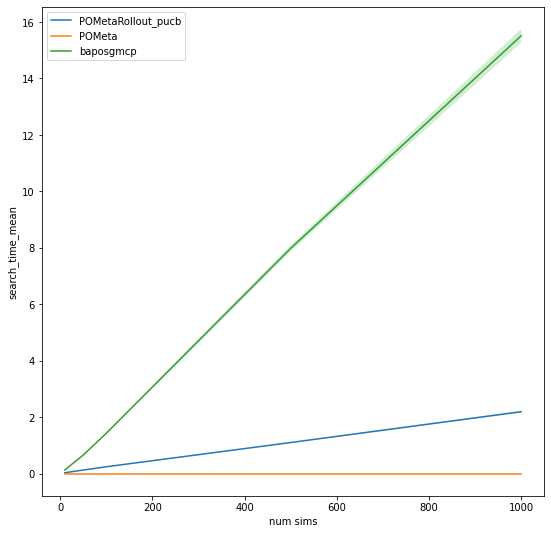

In [35]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

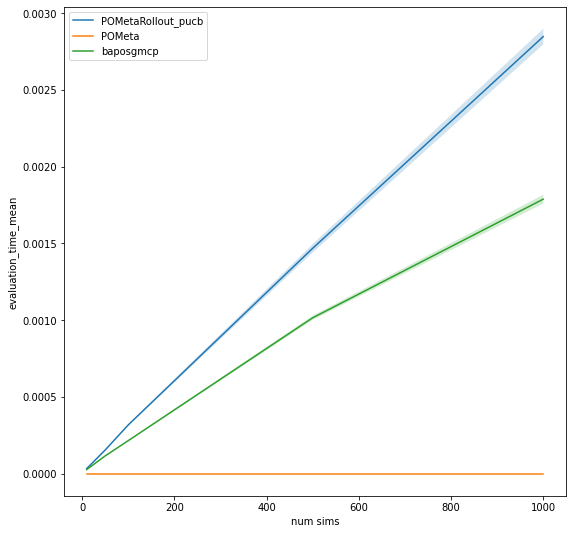

In [36]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

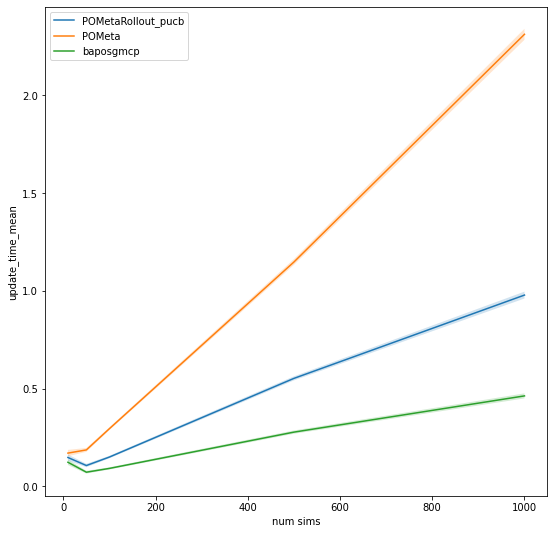

In [37]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

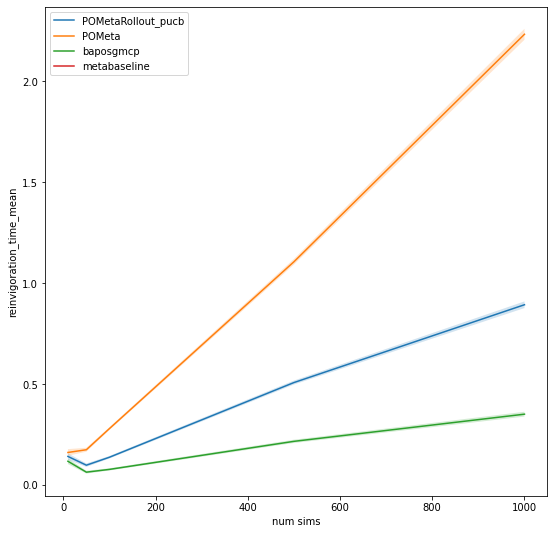

In [38]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

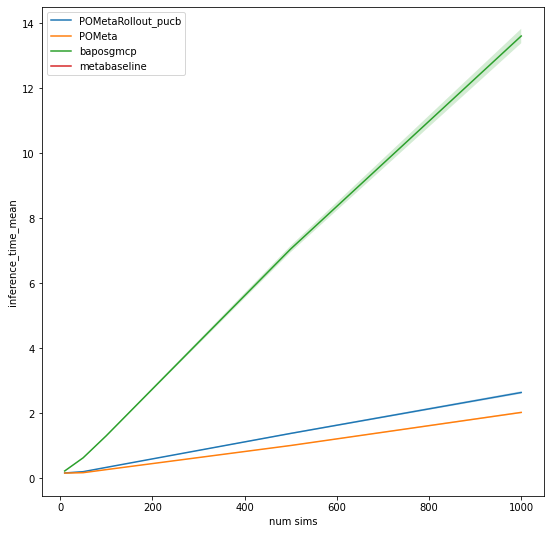

In [39]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

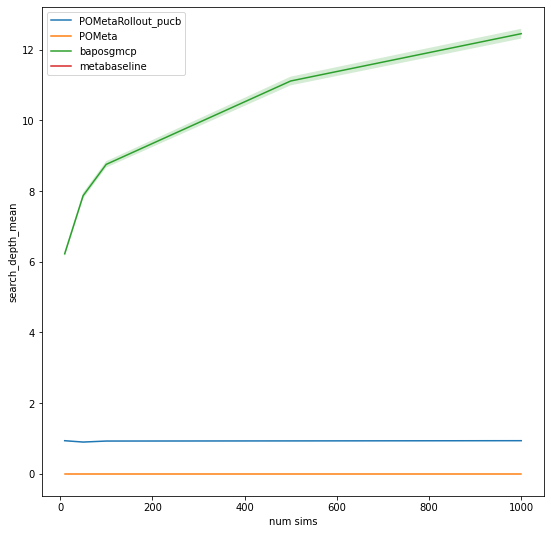

In [40]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [41]:
policy_ids_by_alg = [
    ["baposgmcp_10", "baposgmcp_50", "baposgmcp_100", "baposgmcp_500", "baposgmcp_1000"],
]

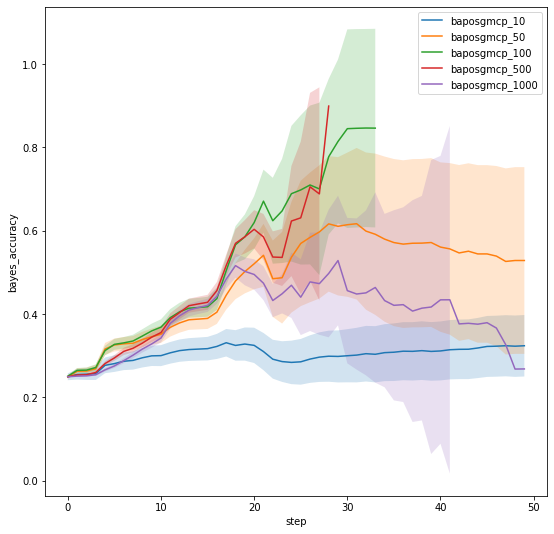

In [42]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="bayes_accuracy",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)

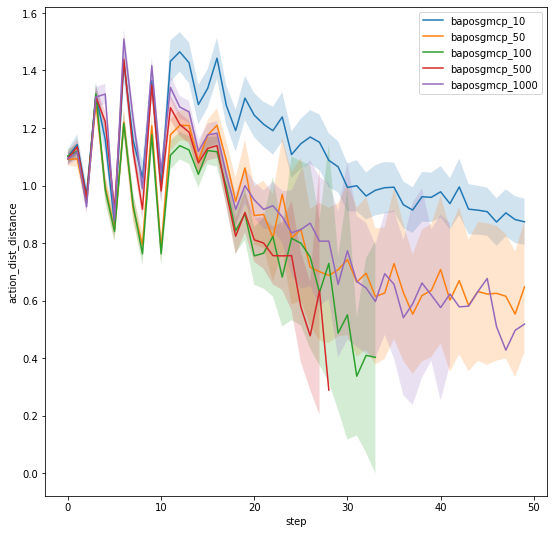

In [43]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="action_dist_distance",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)